# Neural Combinatorial Optimization

In [1]:
#-*- coding: utf-8 -*-
import tensorflow as tf
distr = tf.contrib.distributions

import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

from utils import embed_seq, encode_seq, full_glimpse, pointer
from data_generator import DataGenerator


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Proposal
### Study the learning behaviour of the method in terms of episodes and hyperparameter values.

#### How: change data, network and train/test parameters in [3]



### Remove the baseline policy from the objective function, and assess the impact on learning.


### Investigate the effect of instead waiting for an episode to end using Monte Carlo sampling in REINFORCE, applying bootstrapping and updating the policy parameters at each time step, by the use TD(0) for policy gradients and compare the learning rate of both approaches.


### Additionally, we would like to try to improve the learning by implementing n-step returns and also TD($\lambda$) with eligibility traces. 

## 1. Data Generator

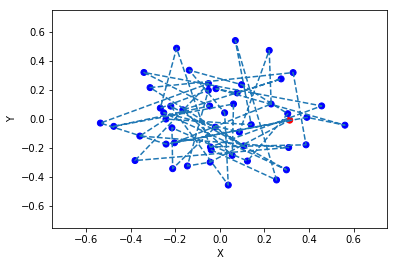

In [2]:
dataset = DataGenerator() # Create Data Generator

input_batch = dataset.test_batch(batch_size=128, max_length=50, dimension=2, seed=123) # Generate some data
dataset.visualize_2D_trip(input_batch[0]) # 2D plot for coord batch

## 2. Config

In [3]:
import argparse

parser = argparse.ArgumentParser(description='Configuration file')
arg_lists = []

def add_argument_group(name):
  arg = parser.add_argument_group(name)
  arg_lists.append(arg)
  return arg

def str2bool(v):
  return v.lower() in ('true', '1')

# Data
data_arg = add_argument_group('Data')
data_arg.add_argument('--batch_size', type=int, default=256, help='batch size')
data_arg.add_argument('--max_length', type=int, default=50, help='number of cities') ##### #####
data_arg.add_argument('--dimension', type=int, default=2, help='city dimension')

# Network
net_arg = add_argument_group('Network')
net_arg.add_argument('--input_embed', type=int, default=128, help='actor critic input embedding')
net_arg.add_argument('--num_neurons', type=int, default=512, help='encoder inner layer neurons')
net_arg.add_argument('--num_stacks', type=int, default=3, help='encoder num stacks')
net_arg.add_argument('--num_heads', type=int, default=16, help='encoder num heads')
net_arg.add_argument('--query_dim', type=int, default=360, help='decoder query space dimension')
net_arg.add_argument('--num_units', type=int, default=256, help='decoder and critic attention product space')
net_arg.add_argument('--num_neurons_critic', type=int, default=256, help='critic n-1 layer')

# Train / test parameters
train_arg = add_argument_group('Training')
train_arg.add_argument('--nb_steps', type=int, default=10, help='nb steps')
train_arg.add_argument('--init_B', type=float, default=7., help='critic init baseline')
train_arg.add_argument('--lr_start', type=float, default=0.001, help='actor learning rate')
train_arg.add_argument('--lr_decay_step', type=int, default=5000, help='lr1 decay step')
train_arg.add_argument('--lr_decay_rate', type=float, default=0.96, help='lr1 decay rate')
train_arg.add_argument('--temperature', type=float, default=1.0, help='pointer initial temperature')
train_arg.add_argument('--C', type=float, default=10.0, help='pointer tanh clipping')
train_arg.add_argument('--is_training', type=str2bool, default=True, help='switch to inference mode when model is trained') 

def get_config():
  config, unparsed = parser.parse_known_args()
  return config, unparsed

In [4]:
config, _ = get_config()
dir_ = str(config.dimension)+'D_'+'TSP'+str(config.max_length) +'_b'+str(config.batch_size)+'_e'+str(config.input_embed)+'_n'+str(config.num_neurons)+'_s'+str(config.num_stacks)+'_h'+str(config.num_heads)+ '_q'+str(config.query_dim) +'_u'+str(config.num_units)+'_c'+str(config.num_neurons_critic)+ '_lr'+str(config.lr_start)+'_d'+str(config.lr_decay_step)+'_'+str(config.lr_decay_rate)+ '_T'+str(config.temperature)+ '_steps'+str(config.nb_steps)+'_i'+str(config.init_B) 
print(dir_)

2D_TSP50_b256_e128_n512_s3_h16_q360_u256_c256_lr0.001_d5000_0.96_T1.0_steps10_i7.0


## 3. Model

In [1]:
class Actor(object):
    
    def __init__(self):
        
        # Data config
        self.batch_size = config.batch_size # batch size
        self.max_length = config.max_length # input sequence length (number of cities)
        self.dimension = config.dimension # dimension of a city (coordinates)
        
        # Network config
        self.input_embed = config.input_embed # dimension of embedding space
        self.num_neurons = config.num_neurons # dimension of hidden states (encoder)
        self.num_stacks = config.num_stacks # encoder num stacks
        self.num_heads = config.num_heads # encoder num heads
        self.query_dim = config.query_dim # decoder query space dimension
        self.num_units = config.num_units # dimension of attention product space (decoder and critic)
        self.num_neurons_critic = config.num_neurons_critic # critic n-1 layer num neurons
        self.initializer = tf.contrib.layers.xavier_initializer() # variables initializer
        
        # Training config (actor and critic)
        self.global_step = tf.Variable(0, trainable=False, name="global_step") # actor global step
        self.global_step2 = tf.Variable(0, trainable=False, name="global_step2") # critic global step
        self.init_B = config.init_B # critic initial baseline
        self.lr_start = config.lr_start # initial learning rate
        self.lr_decay_step = config.lr_decay_step # learning rate decay step
        self.lr_decay_rate = config.lr_decay_rate # learning rate decay rate
        self.is_training = config.is_training # swith to False if test mode

        # Tensor block holding the input sequences [Batch Size, Sequence Length, Features]
        self.input_ = tf.placeholder(tf.float32, [None, self.max_length, self.dimension], name="input_coordinates")
        
        with tf.variable_scope("actor"): self.encode_decode()
        with tf.variable_scope("critic"): self.build_critic()
        with tf.variable_scope("environment"): self.build_reward()
        with tf.variable_scope("optimizer"): self.build_optim()
        self.merged = tf.summary.merge_all()    
        
        
    def encode_decode(self):
        actor_embedding = embed_seq(input_seq=self.input_, from_=self.dimension, to_= self.input_embed, is_training=self.is_training, BN=True, initializer=self.initializer)
        actor_encoding = encode_seq(input_seq=actor_embedding, input_dim=self.input_embed, num_stacks=self.num_stacks, num_heads=self.num_heads, num_neurons=self.num_neurons, is_training=self.is_training)
        if self.is_training == False:
            actor_encoding = tf.tile(actor_encoding,[self.batch_size,1,1])
        
        idx_list, log_probs, entropies = [], [], [] # tours index, log_probs, entropies
        mask = tf.zeros((self.batch_size, self.max_length)) # mask for actions
        
        n_hidden = actor_encoding.get_shape().as_list()[2] # input_embed
        W_ref = tf.get_variable("W_ref",[1, n_hidden, self.num_units],initializer=self.initializer)
        W_q = tf.get_variable("W_q",[self.query_dim, self.num_units],initializer=self.initializer)
        v = tf.get_variable("v",[self.num_units],initializer=self.initializer)
        
        encoded_ref = tf.nn.conv1d(actor_encoding, W_ref, 1, "VALID") # actor_encoding is the ref for actions [Batch size, seq_length, n_hidden]
        query1 = tf.zeros((self.batch_size, n_hidden)) # initial state
        query2 = tf.zeros((self.batch_size, n_hidden)) # previous state
        query3 = tf.zeros((self.batch_size, n_hidden)) # previous previous state
            
        W_1 =tf.get_variable("W_1",[n_hidden, self.query_dim],initializer=self.initializer) # update trajectory (state)
        W_2 =tf.get_variable("W_2",[n_hidden, self.query_dim],initializer=self.initializer)
        W_3 =tf.get_variable("W_3",[n_hidden, self.query_dim],initializer=self.initializer)
    
        for step in range(self.max_length): # sample from POINTER      
            query = tf.nn.relu(tf.matmul(query1, W_1) + tf.matmul(query2, W_2) + tf.matmul(query3, W_3))
            logits = pointer(encoded_ref=encoded_ref, query=query, mask=mask, W_ref=W_ref, W_q=W_q, v=v, C=config.C, temperature=config.temperature)
            prob = distr.Categorical(logits) # logits = masked_scores
            idx = prob.sample()
            
            idx_list.append(idx) # tour index
            log_probs.append(prob.log_prob(idx)) # log prob
            entropies.append(prob.entropy()) # entropies
            mask = mask + tf.one_hot(idx, self.max_length) # mask
            
            idx_ = tf.stack([tf.range(self.batch_size,dtype=tf.int32), idx],1) # idx with batch   
            query3 = query2
            query2 = query1
            query1 = tf.gather_nd(actor_encoding, idx_) # update trajectory (state)
            
        idx_list.append(idx_list[0]) # return to start
        self.tour = tf.stack(idx_list, axis=1) # permutations
        self.log_prob = tf.add_n(log_probs) # corresponding log-probability for backprop
        self.entropies = tf.add_n(entropies)
        tf.summary.scalar('log_prob_mean', tf.reduce_mean(self.log_prob))
        tf.summary.scalar('entropies_mean', tf.reduce_mean(self.entropies))
        
        
    def build_reward(self): # reorder input % tour and return tour length (euclidean distance)
        self.permutations = tf.stack([tf.tile(tf.expand_dims(tf.range(self.batch_size,dtype=tf.int32),1),[1,self.max_length+1]),self.tour],2)
        if self.is_training==True:
            self.ordered_input_ = tf.gather_nd(self.input_,self.permutations)
        else:
            self.ordered_input_ = tf.gather_nd(tf.tile(self.input_,[self.batch_size,1,1]),self.permutations)
        self.ordered_input_ = tf.transpose(self.ordered_input_,[2,1,0]) # [features, seq length +1, batch_size]   Rq: +1 because end = start    
        
        ordered_x_ = self.ordered_input_[0] # ordered x, y coordinates [seq length +1, batch_size]
        ordered_y_ = self.ordered_input_[1] # ordered y coordinates [seq length +1, batch_size]          
        delta_x2 = tf.transpose(tf.square(ordered_x_[1:]-ordered_x_[:-1]),[1,0]) # [batch_size, seq length]        delta_x**2
        delta_y2 = tf.transpose(tf.square(ordered_y_[1:]-ordered_y_[:-1]),[1,0]) # [batch_size, seq length]        delta_y**2

        inter_city_distances = tf.sqrt(delta_x2+delta_y2) # sqrt(delta_x**2 + delta_y**2) this is the euclidean distance between each city: depot --> ... ---> depot      [batch_size, seq length]
        self.distances = tf.reduce_sum(inter_city_distances, axis=1) # [batch_size]
        self.reward = tf.cast(self.distances,tf.float32) # define reward from tour length  
        tf.summary.scalar('reward_mean', tf.reduce_mean(self.reward))

            
    def build_critic(self):
        critic_embedding = embed_seq(input_seq=self.input_, from_=self.dimension, to_= self.input_embed, is_training=self.is_training, BN=True, initializer=self.initializer)
        critic_encoding = encode_seq(input_seq=critic_embedding, input_dim=self.input_embed, num_stacks=self.num_stacks, num_heads=self.num_heads, num_neurons=self.num_neurons, is_training=self.is_training)
        frame = full_glimpse(ref=critic_encoding, from_=self.input_embed, to_=self.num_units, initializer=tf.contrib.layers.xavier_initializer()) # Glimpse on critic_encoding [Batch_size, input_embed]
        
        with tf.variable_scope("ffn"): #  2 dense layers for predictions
            h0 = tf.layers.dense(frame, self.num_neurons_critic, activation=tf.nn.relu, kernel_initializer=self.initializer)
            w1 = tf.get_variable("w1", [self.num_neurons_critic, 1], initializer=self.initializer)
            b1 = tf.Variable(self.init_B, name="b1")
            self.predictions = tf.squeeze(tf.matmul(h0, w1)+b1)
            tf.summary.scalar('predictions_mean', tf.reduce_mean(self.predictions))
            
    def build_optim(self):
        update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
        with tf.control_dependencies(update_ops): # Update moving_mean and moving_variance for BN
            
            with tf.name_scope('reinforce'):
                lr1 = tf.train.natural_exp_decay(learning_rate=self.lr_start, global_step=self.global_step, decay_steps=self.lr_decay_step, decay_rate=self.lr_decay_rate, staircase=False, name="learning_rate1") # learning rate actor
                tf.summary.scalar('lr', lr1)
                opt1 = tf.train.AdamOptimizer(learning_rate=lr1) # Optimizer
                self.loss = tf.reduce_mean(tf.stop_gradient(self.reward-self.predictions)*self.log_prob, axis=0) # loss actor
                gvs1 = opt1.compute_gradients(self.loss) # gradients
                capped_gvs1 = [(tf.clip_by_norm(grad, 1.), var) for grad, var in gvs1 if grad is not None] # L2 clip
                self.trn_op1 = opt1.apply_gradients(grads_and_vars=capped_gvs1, global_step=self.global_step) # minimize op actor
                
            with tf.name_scope('state_value'):
                lr2 = tf.train.natural_exp_decay(learning_rate=self.lr_start, global_step=self.global_step2, decay_steps=self.lr_decay_step, decay_rate=self.lr_decay_rate, staircase=False, name="learning_rate2") # learning rate critic
                opt2 = tf.train.AdamOptimizer(learning_rate=lr2) # Optimizer
                loss2 = tf.losses.mean_squared_error(self.reward, self.predictions) # loss critic
                gvs2 = opt2.compute_gradients(loss2) # gradients
                capped_gvs2 = [(tf.clip_by_norm(grad, 1.), var) for grad, var in gvs2 if grad is not None] # L2 clip
                self.trn_op2 = opt2.apply_gradients(grads_and_vars=capped_gvs2, global_step=self.global_step2) # minimize op critic

In [ ]:
tf.reset_default_graph()
actor = Actor() # Build graph

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use keras.layers.conv1d instead.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.
Instructions for updating:
Use tf.random.categorical instead.
Instructions for updating:

In [ ]:
variables_to_save = [v for v in tf.global_variables() if 'Adam' not in v.name] # Save & restore all the variables.
saver = tf.train.Saver(var_list=variables_to_save, keep_checkpoint_every_n_hours=1.0)   

In [ ]:
with tf.Session() as sess: # start session
    sess.run(tf.global_variables_initializer()) # Run initialize op
    variables_names = [v.name for v in tf.trainable_variables() if 'Adam' not in v.name]
    values = sess.run(variables_names)
    for k, v in zip(variables_names, values):
        #print("Variable: ", k, "Shape: ", v.shape) # print all variables
        pass

## 4. Train

In [ ]:
np.random.seed(123) # reproducibility
tf.set_random_seed(123)

In [ ]:
with tf.Session() as sess: # start session
    sess.run(tf.global_variables_initializer()) # run initialize op
    writer = tf.summary.FileWriter('summary/'+dir_, sess.graph) # summary writer
    
    for i in tqdm(range(config.nb_steps)): # Forward pass & train step
        input_batch = dataset.train_batch(actor.batch_size, actor.max_length, actor.dimension)
        feed = {actor.input_: input_batch} # get feed dict
        reward, predictions, summary, _, _ = sess.run([actor.reward, actor.predictions, actor.merged, actor.trn_op1, actor.trn_op2], feed_dict=feed)

        if i % 50 == 0: 
            print('reward',np.mean(reward))
            print('predictions',np.mean(predictions))
            writer.add_summary(summary,i)
        
    save_path = "save/"+dir_
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    saver.save(sess, save_path+"/actor.ckpt") # save the variables to disk
    print("Training COMPLETED! Model saved in file: %s" % save_path)

 10%|█         | 1/10 [00:18<02:48, 18.75s/it]

reward 20.13182
predictions 7.329376


100%|██████████| 10/10 [00:58<00:00,  5.34s/it]


Training COMPLETED! Model saved in file: save/2D_TSP50_b256_e128_n512_s3_h16_q360_u256_c256_lr0.001_d5000_0.96_T1.0_steps10_i7.0


##  5. Test

In [ ]:
config.is_training = False
config.batch_size = 10 ##### #####
config.max_length = 50 ##### #####
config.temperature = 1.2 ##### #####

tf.reset_default_graph()
actor = Actor() # Build graph

In [ ]:
variables_to_save = [v for v in tf.global_variables() if 'Adam' not in v.name] # Save & restore all the variables.
saver = tf.train.Saver(var_list=variables_to_save, keep_checkpoint_every_n_hours=1.0)   

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from save/2D_TSP50_b256_e128_n512_s3_h16_q360_u256_c256_lr0.001_d5000_0.96_T1.0_steps10_i7.0/actor.ckpt


  0%|          | 0/1000 [00:00<?, ?it/s]

reward (before 2 opt) 17.020622
reward (with 2 opt) 5.743098687654854


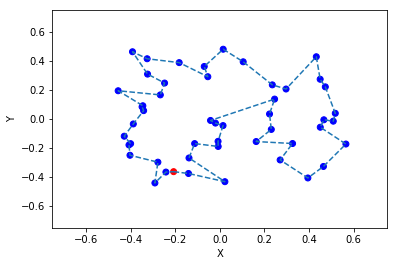

  0%|          | 1/1000 [00:02<34:39,  2.08s/it]

reward (before 2 opt) 15.535362
reward (with 2 opt) 5.7720753885079645


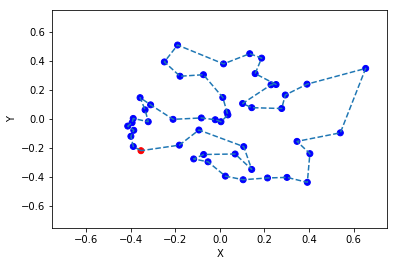

  0%|          | 2/1000 [00:02<28:11,  1.70s/it]

reward (before 2 opt) 16.886011
reward (with 2 opt) 5.929931150027763


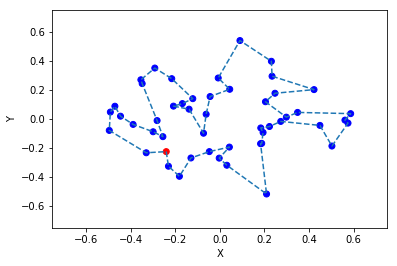

  0%|          | 3/1000 [00:03<24:30,  1.47s/it]

reward (before 2 opt) 17.826984
reward (with 2 opt) 6.30127390555316


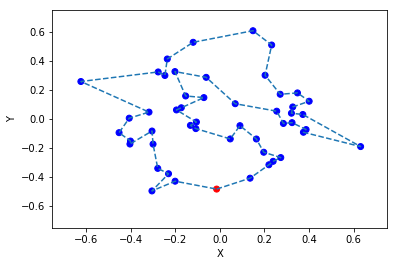

  0%|          | 4/1000 [00:05<23:38,  1.42s/it]

reward (before 2 opt) 16.839188
reward (with 2 opt) 6.058782117036852


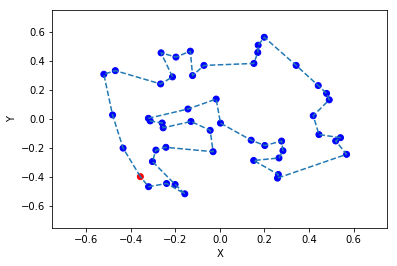

  0%|          | 5/1000 [00:06<21:41,  1.31s/it]

reward (before 2 opt) 17.633482
reward (with 2 opt) 6.39416909384322


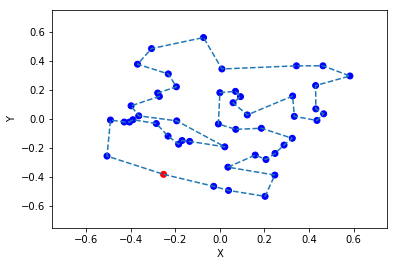

  1%|          | 6/1000 [00:06<18:52,  1.14s/it]

reward (before 2 opt) 14.738026
reward (with 2 opt) 6.437993970442023


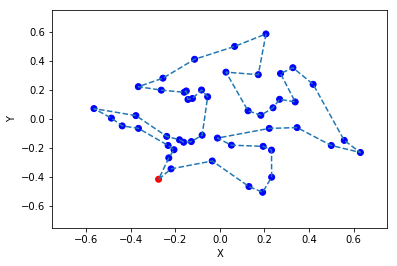

  1%|          | 7/1000 [00:07<17:15,  1.04s/it]

reward (before 2 opt) 17.883701
reward (with 2 opt) 6.487061909983174


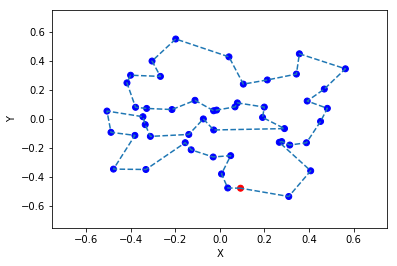

  1%|          | 8/1000 [00:08<18:07,  1.10s/it]

reward (before 2 opt) 16.022152
reward (with 2 opt) 5.59796982530664


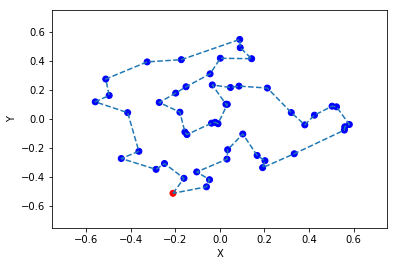

  1%|          | 9/1000 [00:09<16:06,  1.03it/s]

reward (before 2 opt) 16.149517
reward (with 2 opt) 6.1281055740527135


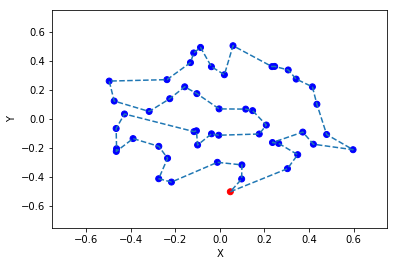

  1%|          | 10/1000 [00:10<15:19,  1.08it/s]

reward (before 2 opt) 17.98294
reward (with 2 opt) 6.159630713342578


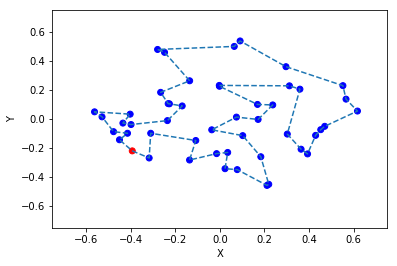

  1%|          | 11/1000 [00:11<15:11,  1.08it/s]

reward (before 2 opt) 16.268055
reward (with 2 opt) 6.082589397047849


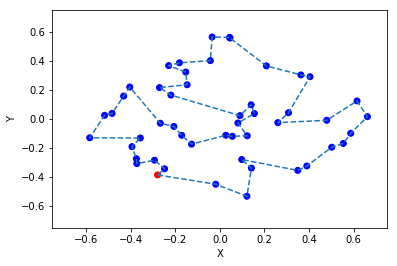

  1%|          | 12/1000 [00:12<14:22,  1.14it/s]

reward (before 2 opt) 16.44188
reward (with 2 opt) 6.048874908474227


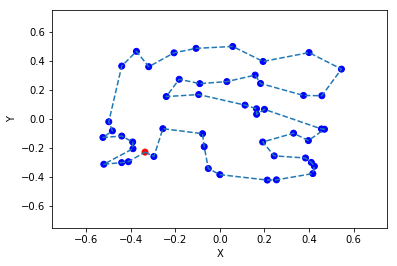

  1%|▏         | 13/1000 [00:13<14:51,  1.11it/s]

reward (before 2 opt) 17.344067
reward (with 2 opt) 5.886134222613136


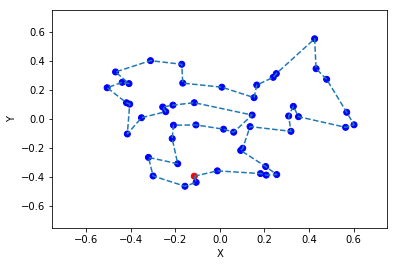

  1%|▏         | 14/1000 [00:13<13:48,  1.19it/s]

reward (before 2 opt) 15.801965
reward (with 2 opt) 5.426184049889385


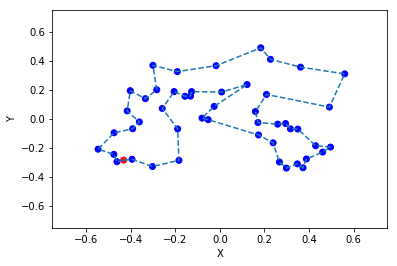

  2%|▏         | 15/1000 [00:14<13:38,  1.20it/s]

reward (before 2 opt) 17.664257
reward (with 2 opt) 5.998647242034488


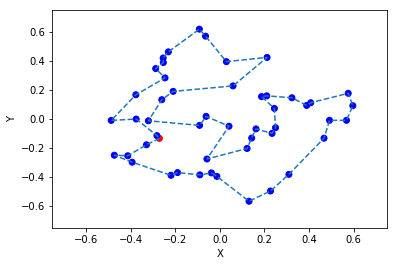

  2%|▏         | 16/1000 [00:16<17:16,  1.05s/it]

reward (before 2 opt) 16.320185
reward (with 2 opt) 5.7544312007046905


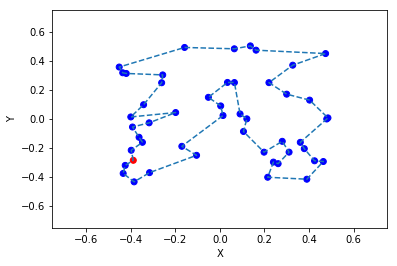

  2%|▏         | 17/1000 [00:17<16:48,  1.03s/it]

reward (before 2 opt) 18.27798
reward (with 2 opt) 6.2133699300583745


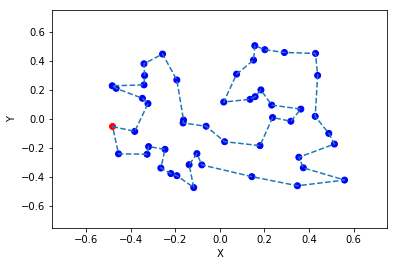

  2%|▏         | 18/1000 [00:18<16:52,  1.03s/it]

reward (before 2 opt) 18.579353
reward (with 2 opt) 6.5954940760460286


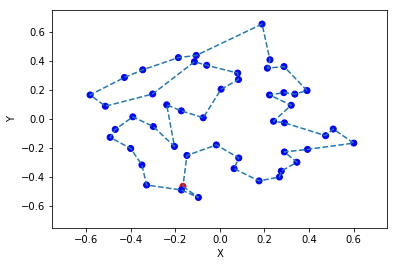

  2%|▏         | 19/1000 [00:19<16:09,  1.01it/s]

reward (before 2 opt) 15.380908
reward (with 2 opt) 5.406024050840181


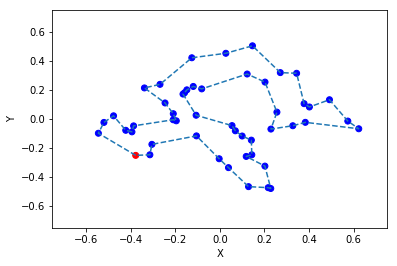

  2%|▏         | 20/1000 [00:19<14:24,  1.13it/s]

reward (before 2 opt) 15.816553
reward (with 2 opt) 5.639818339442418


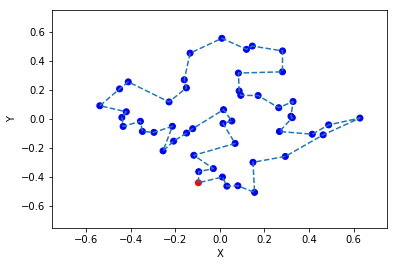

  2%|▏         | 21/1000 [00:20<15:13,  1.07it/s]

reward (before 2 opt) 16.548235
reward (with 2 opt) 6.348196190623891


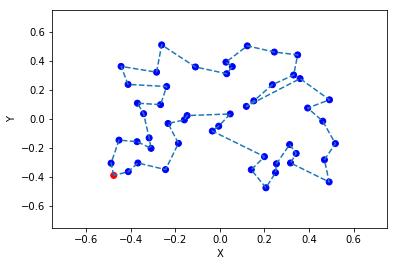

  2%|▏         | 22/1000 [00:21<14:43,  1.11it/s]

reward (before 2 opt) 16.881546
reward (with 2 opt) 5.576065813952239


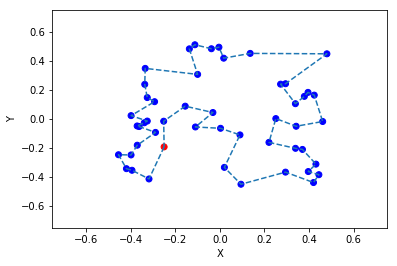

  2%|▏         | 23/1000 [00:22<15:50,  1.03it/s]

reward (before 2 opt) 18.221888
reward (with 2 opt) 6.192093415264889


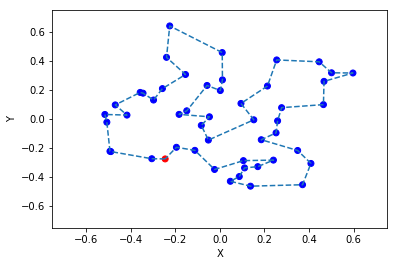

  2%|▏         | 24/1000 [00:23<15:43,  1.03it/s]

reward (before 2 opt) 14.248497
reward (with 2 opt) 5.412146209695372


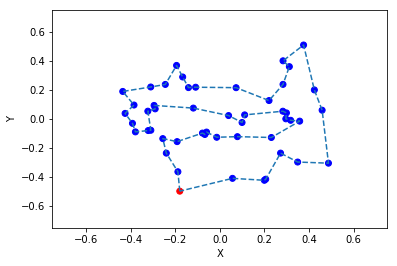

  2%|▎         | 25/1000 [00:24<14:47,  1.10it/s]

reward (before 2 opt) 19.030653
reward (with 2 opt) 6.228567062244172


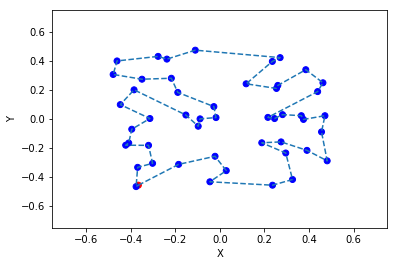

  3%|▎         | 26/1000 [00:25<14:29,  1.12it/s]

reward (before 2 opt) 14.93656
reward (with 2 opt) 6.182057316499216


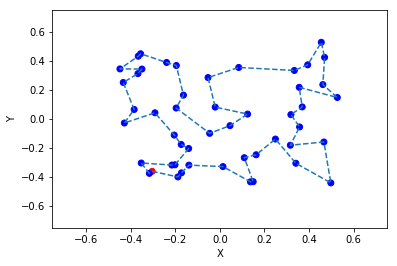

  3%|▎         | 27/1000 [00:26<14:52,  1.09it/s]

reward (before 2 opt) 17.950022
reward (with 2 opt) 6.085201874266877


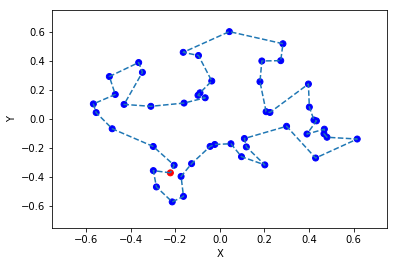

  3%|▎         | 28/1000 [00:27<14:29,  1.12it/s]

reward (before 2 opt) 15.589838
reward (with 2 opt) 6.12521955440424


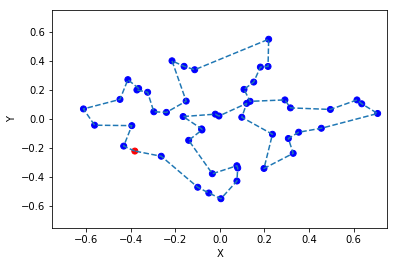

  3%|▎         | 29/1000 [00:27<13:29,  1.20it/s]

reward (before 2 opt) 16.108358
reward (with 2 opt) 6.620931500272497


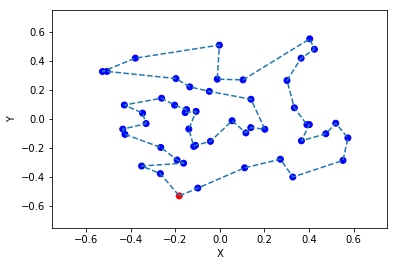

  3%|▎         | 30/1000 [00:28<13:26,  1.20it/s]

reward (before 2 opt) 16.681683
reward (with 2 opt) 5.979739441094729


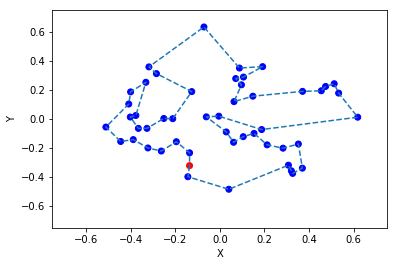

  3%|▎         | 31/1000 [00:29<14:09,  1.14it/s]

reward (before 2 opt) 17.729315
reward (with 2 opt) 6.070654308100122


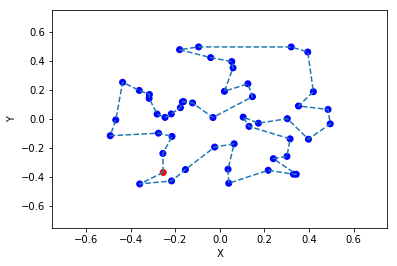

  3%|▎         | 32/1000 [00:30<13:25,  1.20it/s]

reward (before 2 opt) 16.159103
reward (with 2 opt) 6.220167250010072


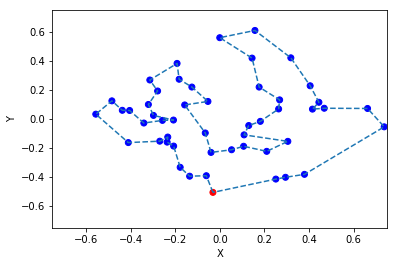

  3%|▎         | 33/1000 [00:31<14:59,  1.07it/s]

reward (before 2 opt) 17.010122
reward (with 2 opt) 5.768401748158315


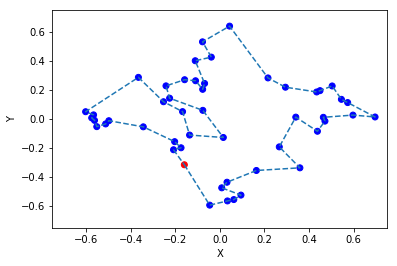

  3%|▎         | 34/1000 [00:32<15:25,  1.04it/s]

reward (before 2 opt) 17.188381
reward (with 2 opt) 6.210795643604848


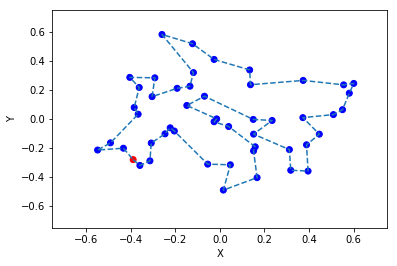

  4%|▎         | 35/1000 [00:33<14:43,  1.09it/s]

reward (before 2 opt) 16.121696
reward (with 2 opt) 5.812050139625133


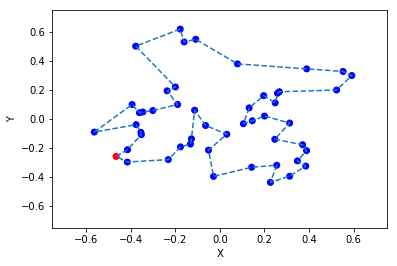

  4%|▎         | 36/1000 [00:34<15:01,  1.07it/s]

reward (before 2 opt) 16.518898
reward (with 2 opt) 6.189641242553395


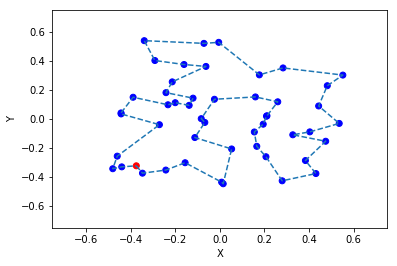

  4%|▎         | 37/1000 [00:35<14:47,  1.08it/s]

reward (before 2 opt) 15.926749
reward (with 2 opt) 5.934094494270541


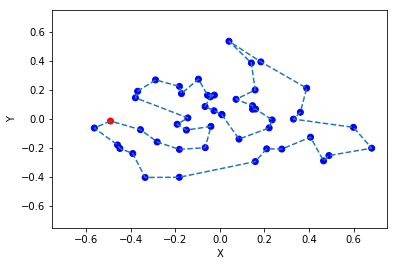

  4%|▍         | 38/1000 [00:36<15:44,  1.02it/s]

reward (before 2 opt) 17.296717
reward (with 2 opt) 6.125172944892941


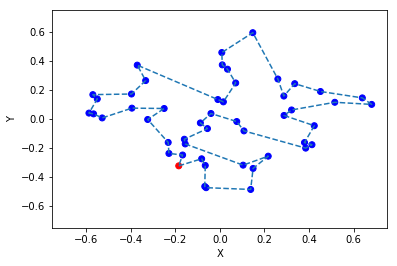

  4%|▍         | 39/1000 [00:37<15:36,  1.03it/s]

reward (before 2 opt) 17.045424
reward (with 2 opt) 5.721465922318609


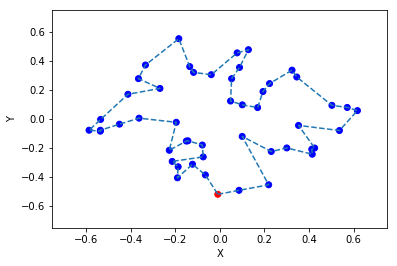

  4%|▍         | 40/1000 [00:38<15:25,  1.04it/s]

reward (before 2 opt) 16.182621
reward (with 2 opt) 5.736278669441042


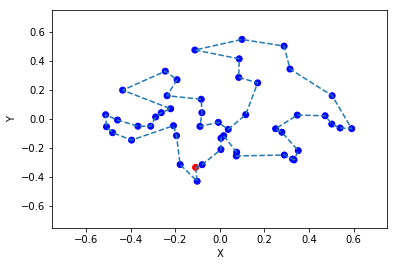

  4%|▍         | 41/1000 [00:39<14:27,  1.11it/s]

reward (before 2 opt) 15.08189
reward (with 2 opt) 5.877764939845576


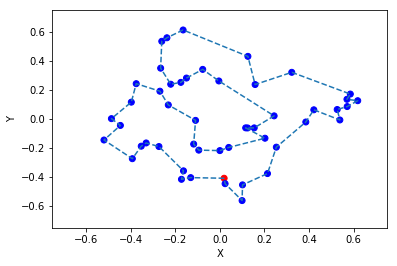

  4%|▍         | 42/1000 [00:39<14:18,  1.12it/s]

reward (before 2 opt) 18.618097
reward (with 2 opt) 6.005778782795381


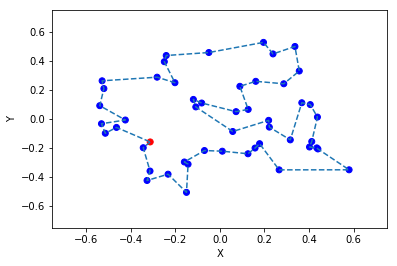

  4%|▍         | 43/1000 [00:40<14:30,  1.10it/s]

reward (before 2 opt) 17.669504
reward (with 2 opt) 6.12672369843614


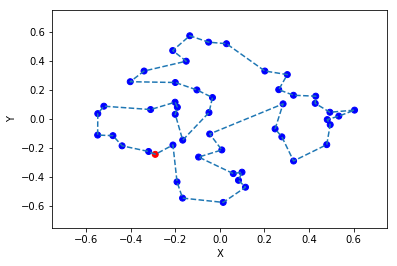

  4%|▍         | 44/1000 [00:41<15:03,  1.06it/s]

reward (before 2 opt) 16.363298
reward (with 2 opt) 5.703580411755405


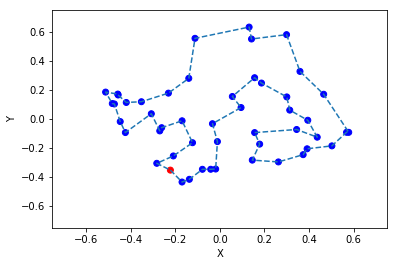

  4%|▍         | 45/1000 [00:42<15:22,  1.04it/s]

reward (before 2 opt) 15.845486
reward (with 2 opt) 5.824064146690545


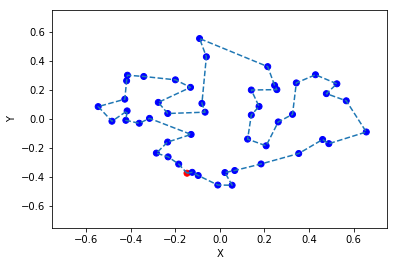

  5%|▍         | 46/1000 [00:43<14:48,  1.07it/s]

reward (before 2 opt) 15.514083
reward (with 2 opt) 5.78657572026181


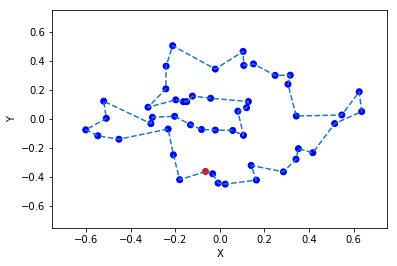

  5%|▍         | 47/1000 [00:44<14:03,  1.13it/s]

reward (before 2 opt) 17.245644
reward (with 2 opt) 6.022491051629257


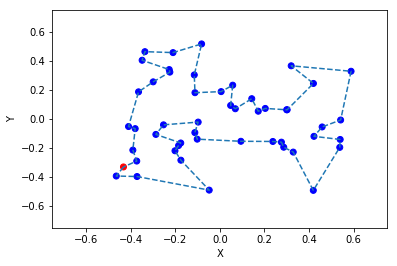

  5%|▍         | 48/1000 [00:45<13:55,  1.14it/s]

reward (before 2 opt) 18.27347
reward (with 2 opt) 6.183487666059476


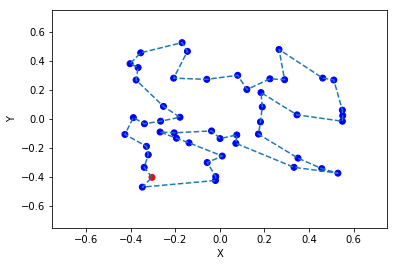

  5%|▍         | 49/1000 [00:46<13:43,  1.15it/s]

reward (before 2 opt) 17.456741
reward (with 2 opt) 6.142661404826245


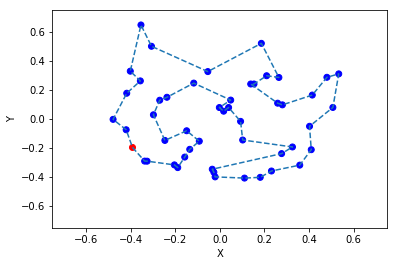

  5%|▌         | 50/1000 [00:47<13:57,  1.13it/s]

reward (before 2 opt) 14.797159
reward (with 2 opt) 5.6242174031493635


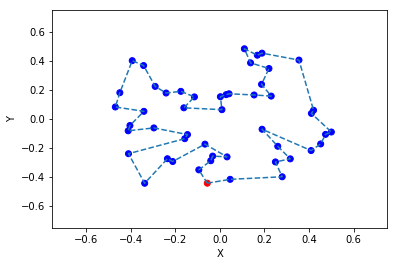

  5%|▌         | 51/1000 [00:48<14:19,  1.10it/s]

reward (before 2 opt) 16.04802
reward (with 2 opt) 6.503952789188005


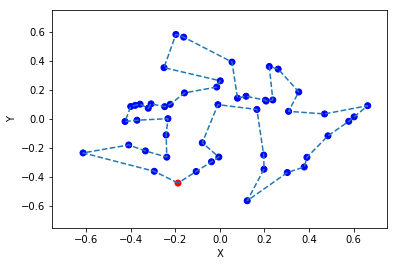

  5%|▌         | 52/1000 [00:48<13:49,  1.14it/s]

reward (before 2 opt) 16.714146
reward (with 2 opt) 5.4941911428022


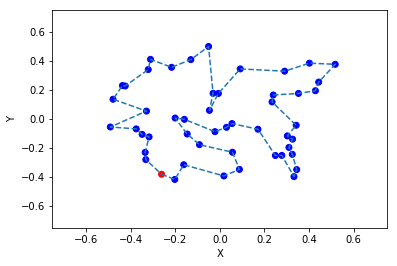

  5%|▌         | 53/1000 [00:49<13:16,  1.19it/s]

reward (before 2 opt) 15.010742
reward (with 2 opt) 5.776584915460099


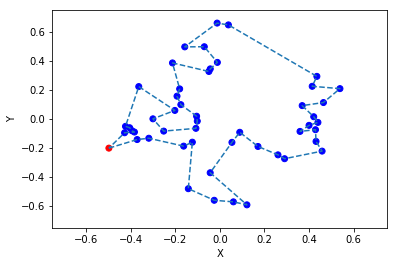

  5%|▌         | 54/1000 [00:50<12:48,  1.23it/s]

reward (before 2 opt) 17.362328
reward (with 2 opt) 6.024498640191893


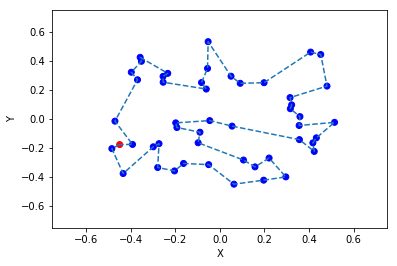

  6%|▌         | 55/1000 [00:51<14:27,  1.09it/s]

reward (before 2 opt) 15.596403
reward (with 2 opt) 5.780818565902059


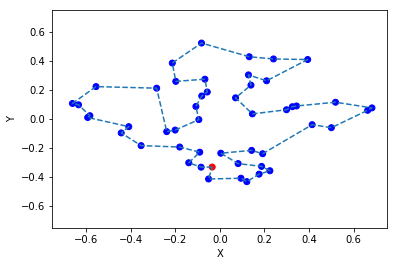

  6%|▌         | 56/1000 [00:52<15:48,  1.01s/it]

reward (before 2 opt) 17.121965
reward (with 2 opt) 6.6873254899768755


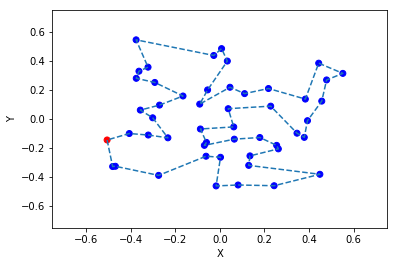

  6%|▌         | 57/1000 [00:53<14:57,  1.05it/s]

reward (before 2 opt) 16.928988
reward (with 2 opt) 6.013820956543806


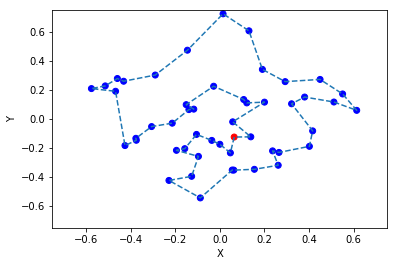

  6%|▌         | 58/1000 [00:54<14:00,  1.12it/s]

reward (before 2 opt) 13.539385
reward (with 2 opt) 5.670024269226383


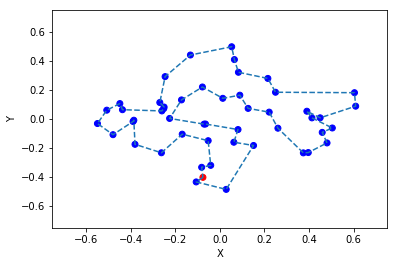

  6%|▌         | 59/1000 [00:55<13:37,  1.15it/s]

reward (before 2 opt) 16.26263
reward (with 2 opt) 6.264039210669494


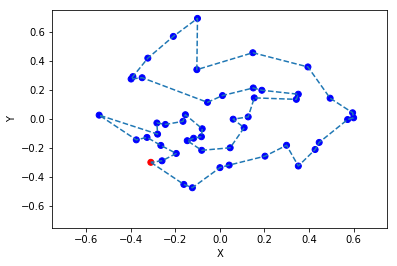

  6%|▌         | 60/1000 [00:56<13:32,  1.16it/s]

reward (before 2 opt) 16.516073
reward (with 2 opt) 5.980521034463853


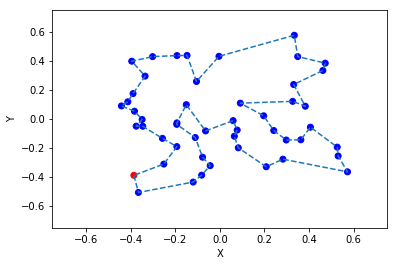

  6%|▌         | 61/1000 [00:56<13:07,  1.19it/s]

reward (before 2 opt) 16.805113
reward (with 2 opt) 5.633382304532215


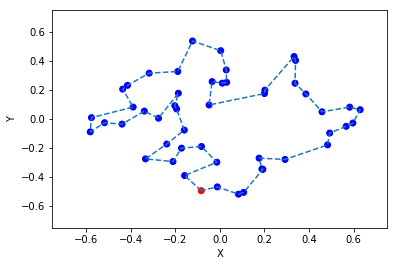

  6%|▌         | 62/1000 [00:57<13:46,  1.13it/s]

reward (before 2 opt) 16.7207
reward (with 2 opt) 6.21309609941279


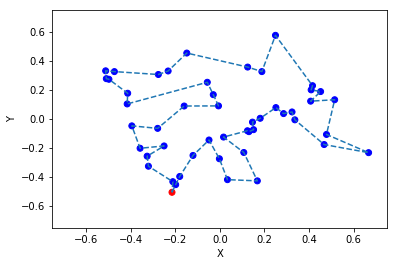

  6%|▋         | 63/1000 [00:58<14:16,  1.09it/s]

reward (before 2 opt) 15.010545
reward (with 2 opt) 6.730502510810511


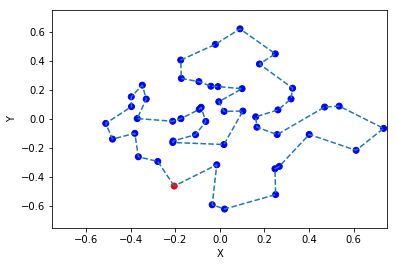

  6%|▋         | 64/1000 [00:59<15:21,  1.02it/s]

reward (before 2 opt) 15.700806
reward (with 2 opt) 5.604742749013478


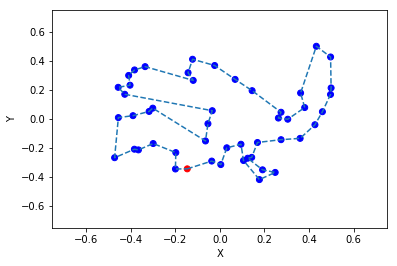

  6%|▋         | 65/1000 [01:00<14:01,  1.11it/s]

reward (before 2 opt) 16.306952
reward (with 2 opt) 5.56305488655308


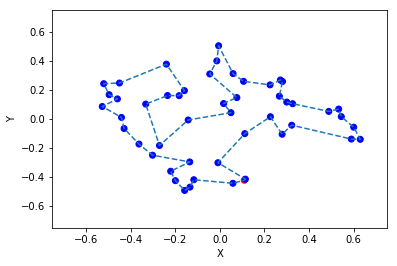

  7%|▋         | 66/1000 [01:02<17:24,  1.12s/it]

reward (before 2 opt) 16.38927
reward (with 2 opt) 6.328801093254344


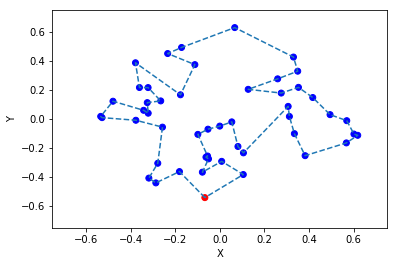

  7%|▋         | 67/1000 [01:03<17:01,  1.09s/it]

reward (before 2 opt) 17.500055
reward (with 2 opt) 5.901915208119676


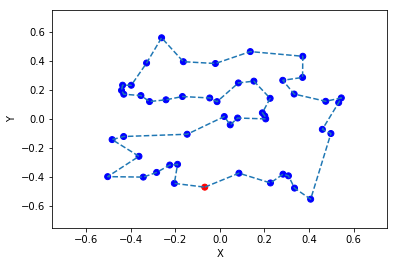

  7%|▋         | 68/1000 [01:04<15:18,  1.01it/s]

reward (before 2 opt) 16.2761
reward (with 2 opt) 6.020157580565709


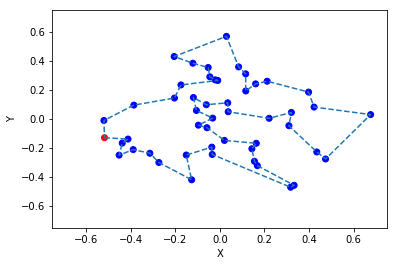

  7%|▋         | 69/1000 [01:05<15:55,  1.03s/it]

reward (before 2 opt) 17.278965
reward (with 2 opt) 6.181545120264436


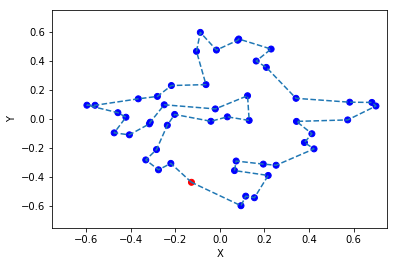

  7%|▋         | 70/1000 [01:05<14:51,  1.04it/s]

reward (before 2 opt) 15.853918
reward (with 2 opt) 6.00328300082052


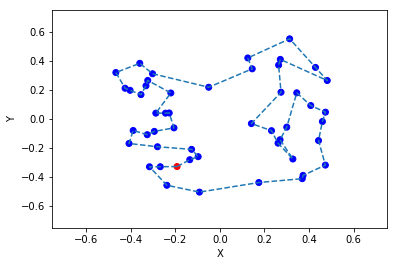

  7%|▋         | 71/1000 [01:06<14:59,  1.03it/s]

reward (before 2 opt) 14.655226
reward (with 2 opt) 5.562906790727002


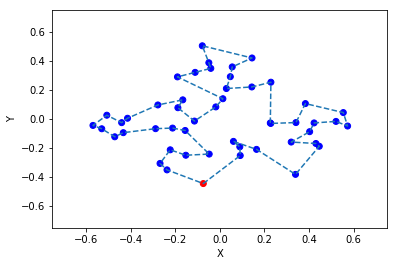

  7%|▋         | 72/1000 [01:07<14:35,  1.06it/s]

reward (before 2 opt) 16.195965
reward (with 2 opt) 6.552615582006666


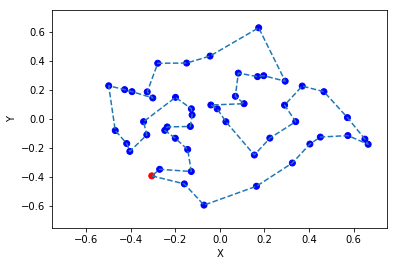

  7%|▋         | 73/1000 [01:08<14:08,  1.09it/s]

reward (before 2 opt) 17.618649
reward (with 2 opt) 6.274181704555161


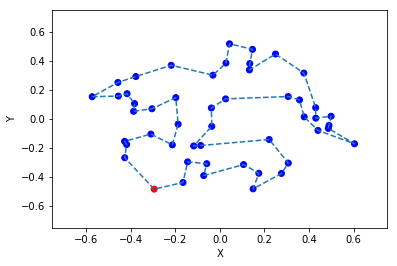

  7%|▋         | 74/1000 [01:09<14:02,  1.10it/s]

reward (before 2 opt) 17.20421
reward (with 2 opt) 5.96816158932817


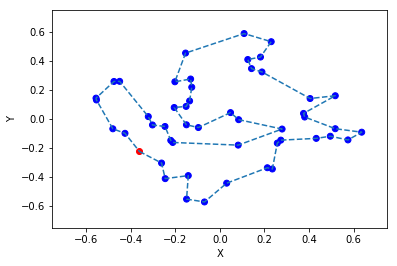

  8%|▊         | 75/1000 [01:10<14:20,  1.08it/s]

reward (before 2 opt) 16.133024
reward (with 2 opt) 5.754557580102133


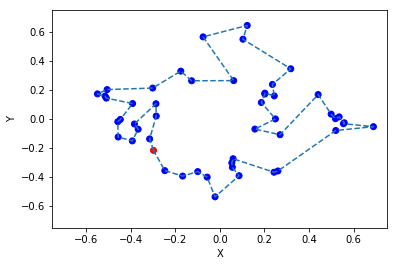

  8%|▊         | 76/1000 [01:11<14:28,  1.06it/s]

reward (before 2 opt) 17.963017
reward (with 2 opt) 5.92878034895481


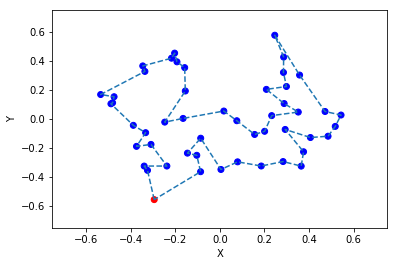

  8%|▊         | 77/1000 [01:13<20:26,  1.33s/it]

reward (before 2 opt) 17.909866
reward (with 2 opt) 5.865512089158596


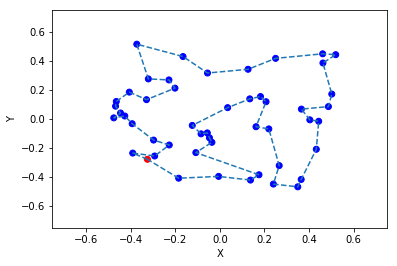

  8%|▊         | 78/1000 [01:14<19:14,  1.25s/it]

reward (before 2 opt) 17.379164
reward (with 2 opt) 5.942903290687117


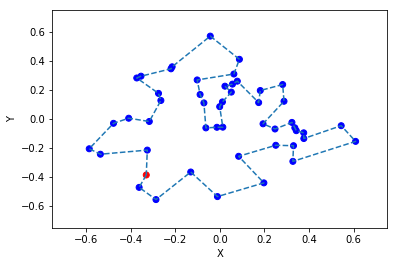

  8%|▊         | 79/1000 [01:15<17:48,  1.16s/it]

reward (before 2 opt) 18.565348
reward (with 2 opt) 6.093123547118429


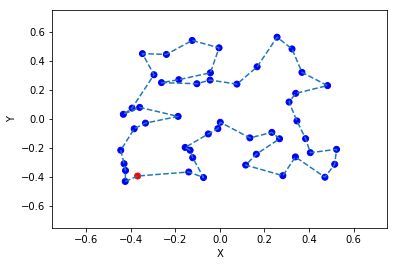

  8%|▊         | 80/1000 [01:16<16:03,  1.05s/it]

reward (before 2 opt) 16.456078
reward (with 2 opt) 5.9755003072030926


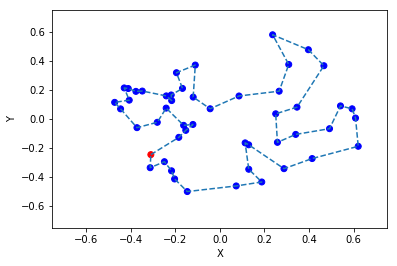

  8%|▊         | 81/1000 [01:17<13:42,  1.12it/s]

reward (before 2 opt) 16.640043
reward (with 2 opt) 6.3266283779445995


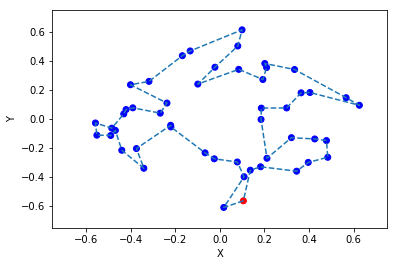

  8%|▊         | 82/1000 [01:18<15:15,  1.00it/s]

reward (before 2 opt) 18.11161
reward (with 2 opt) 5.7069169041312025


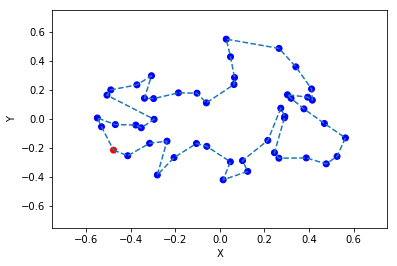

  8%|▊         | 83/1000 [01:19<15:27,  1.01s/it]

reward (before 2 opt) 17.046915
reward (with 2 opt) 6.3249436956398775


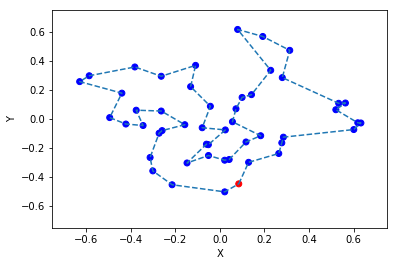

  8%|▊         | 84/1000 [01:20<16:02,  1.05s/it]

reward (before 2 opt) 15.922973
reward (with 2 opt) 6.06958439925966


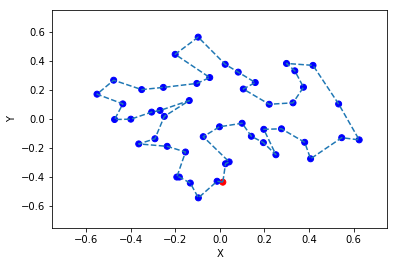

  8%|▊         | 85/1000 [01:21<14:53,  1.02it/s]

reward (before 2 opt) 17.344767
reward (with 2 opt) 5.764656843143845


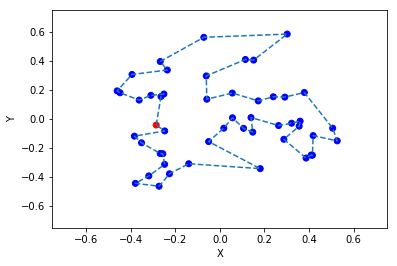

  9%|▊         | 86/1000 [01:21<13:25,  1.13it/s]

reward (before 2 opt) 18.426832
reward (with 2 opt) 6.439037943067195


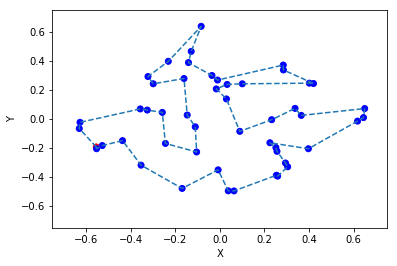

  9%|▊         | 87/1000 [01:22<13:48,  1.10it/s]

reward (before 2 opt) 17.864225
reward (with 2 opt) 6.074331147857061


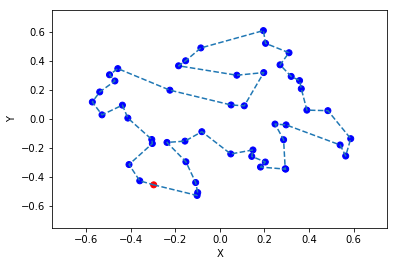

  9%|▉         | 88/1000 [01:24<15:28,  1.02s/it]

reward (before 2 opt) 15.678184
reward (with 2 opt) 5.981743482090722


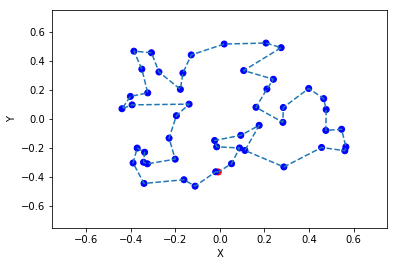

  9%|▉         | 89/1000 [01:25<15:51,  1.04s/it]

reward (before 2 opt) 15.237636
reward (with 2 opt) 5.9251170324303555


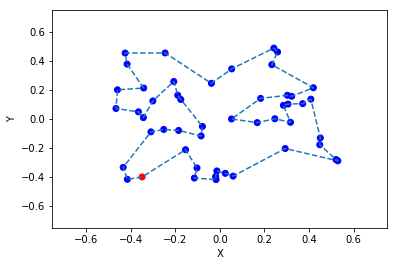

  9%|▉         | 90/1000 [01:26<15:34,  1.03s/it]

reward (before 2 opt) 15.677447
reward (with 2 opt) 6.170429523688635


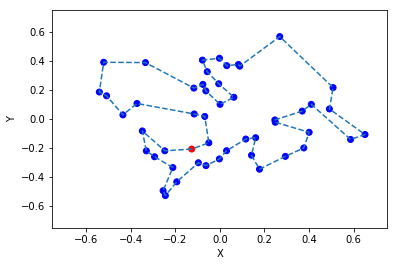

  9%|▉         | 91/1000 [01:26<13:21,  1.13it/s]

reward (before 2 opt) 17.44204
reward (with 2 opt) 6.233426199582745


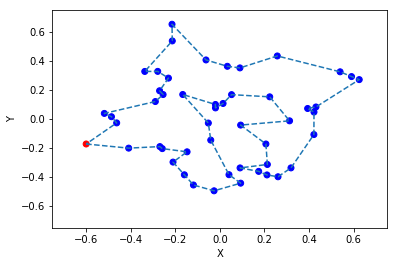

  9%|▉         | 92/1000 [01:28<15:04,  1.00it/s]

reward (before 2 opt) 17.293509
reward (with 2 opt) 6.230187451390863


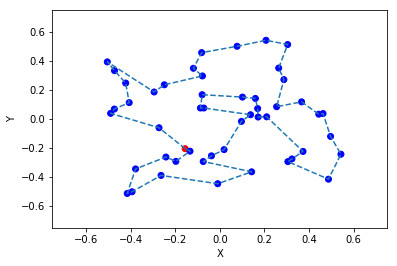

  9%|▉         | 93/1000 [01:28<14:25,  1.05it/s]

reward (before 2 opt) 17.272942
reward (with 2 opt) 5.855861866188426


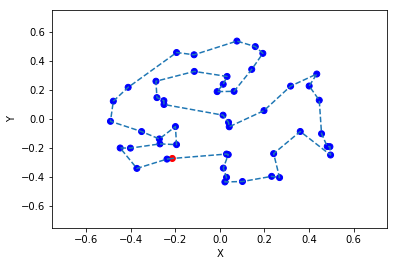

  9%|▉         | 94/1000 [01:29<14:00,  1.08it/s]

reward (before 2 opt) 18.215559
reward (with 2 opt) 5.9075932670189975


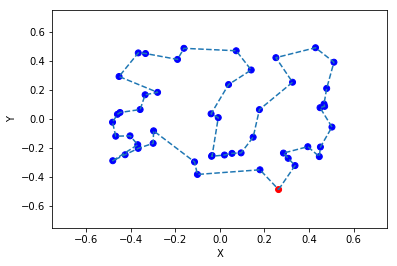

 10%|▉         | 95/1000 [01:31<16:10,  1.07s/it]

reward (before 2 opt) 17.72699


In [ ]:
with tf.Session() as sess:  # start session
    sess.run(tf.global_variables_initializer()) # Run initialize op
    
    save_path = "save/"+dir_
    saver.restore(sess, save_path+"/actor.ckpt") # Restore variables from disk.
    
    predictions_length, predictions_length_w2opt = [], []
    for i in tqdm(range(1000)): # test instance
        seed_ = 1+i
        input_batch = dataset.test_batch(1, actor.max_length, actor.dimension, seed=seed_, shuffle=False)
        feed = {actor.input_: input_batch} # Get feed dict
        tour, reward = sess.run([actor.tour, actor.reward], feed_dict=feed) # sample tours

        j = np.argmin(reward) # find best solution
        best_permutation = tour[j][:-1]
        predictions_length.append(reward[j])
        print('reward (before 2 opt)',reward[j])
        #dataset.visualize_2D_trip(input_batch[0][best_permutation])
        #dataset.visualize_sampling(tour)
        
        opt_tour, opt_length = dataset.loop2opt(input_batch[0][best_permutation])
        predictions_length_w2opt.append(opt_length)
        print('reward (with 2 opt)', opt_length)
        dataset.visualize_2D_trip(opt_tour)
        
    predictions_length = np.asarray(predictions_length) # average tour length
    predictions_length_w2opt = np.asarray(predictions_length_w2opt)
    print("Testing COMPLETED ! Mean length1:",np.mean(predictions_length), "Mean length2:",np.mean(predictions_length_w2opt))

    n1, bins1, patches1 = plt.hist(predictions_length, 50, facecolor='b', alpha=0.75) # Histogram
    n2, bins2, patches2 = plt.hist(predictions_length_w2opt, 50, facecolor='g', alpha=0.75) # Histogram
    plt.xlabel('Tour length')
    plt.ylabel('Counts')
    plt.axis([3., 9., 0, 250])
    plt.grid(True)
    plt.show()